In [3]:
# hangman_solver.py
import os
import random
import math
import pickle
from collections import defaultdict, Counter
from typing import List, Dict, Set
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Settings & Utilities
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def load_wordlist(path: str) -> List[str]:
    """Load lowercase words from a text file (one word per line)."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    with open(path, "r", encoding="utf-8") as f:
        return [w.strip().lower() for w in f if w.strip()]

# -------------------------
# Discrete HMM (unchanged core, small stabilizers)
# -------------------------
class DiscreteHMM:
    """Simple discrete HMM with multinomial emissions."""

    def __init__(self, n_states: int, alphabet: List[str]):
        self.N = n_states
        self.alphabet = alphabet
        self.M = len(alphabet)
        self.sym2idx = {s: i for i, s in enumerate(alphabet)}
        rng = np.random.RandomState(SEED)
        self.pi = rng.dirichlet(np.ones(self.N))
        self.A = rng.dirichlet(np.ones(self.N), size=self.N)
        self.B = rng.dirichlet(np.ones(self.M), size=self.N)

    def _obs_to_idx(self, s: str):
        return np.array([self.sym2idx.get(c, 0) for c in s])

    def _forward_scaled(self, obs):
        T = len(obs)
        alpha = np.zeros((T, self.N))
        scale = np.zeros(T)
        alpha[0] = self.pi * self.B[:, obs[0]]
        scale[0] = alpha[0].sum() or 1e-300
        alpha[0] /= scale[0]
        for t in range(1, T):
            alpha[t] = (alpha[t - 1] @ self.A) * self.B[:, obs[t]]
            scale[t] = alpha[t].sum() or 1e-300
            alpha[t] /= scale[t]
        return alpha, scale, np.sum(np.log(scale + 1e-300))

    def _backward_scaled(self, obs, scale):
        T = len(obs)
        beta = np.zeros((T, self.N))
        beta[-1] = 1.0 / (scale[-1] or 1e-300)
        for t in range(T - 2, -1, -1):
            beta[t] = (self.A @ (self.B[:, obs[t + 1]] * beta[t + 1])) / (scale[t] or 1e-300)
        return beta

    def fit(self, seqs: List[str], n_iter=40, tol=1e-4, verbose=False):
        if not seqs:
            return
        eps = 1e-9
        prev_ll = -1e300
        for it in range(n_iter):
            A_num = np.zeros_like(self.A)
            A_den = np.zeros((self.N, 1))
            B_num = np.zeros_like(self.B)
            B_den = np.zeros((self.N, 1))
            pi_acc = np.zeros(self.N)
            total_ll = 0.0
            for s in seqs:
                obs = self._obs_to_idx(s)
                alpha, scale, ll = self._forward_scaled(obs)
                beta = self._backward_scaled(obs, scale)
                total_ll += ll
                gamma = alpha * beta
                gamma /= gamma.sum(axis=1, keepdims=True) + eps
                pi_acc += gamma[0]
                for t in range(len(obs) - 1):
                    denom = (alpha[t][:, None] * (self.A * (self.B[:, obs[t + 1]] * beta[t + 1])[None, :])).sum()
                    if denom == 0:
                        xi = np.zeros((self.N, self.N))
                    else:
                        xi = (alpha[t][:, None] * (self.A * (self.B[:, obs[t + 1]] * beta[t + 1])[None, :])) / (denom + eps)
                    A_num += xi
                    A_den += gamma[t][:, None]
                for t, o in enumerate(obs):
                    B_num[:, o] += gamma[t]
                B_den += gamma.sum(axis=0)[:, None]
            # update with smoothing
            self.pi = (pi_acc + eps) / (pi_acc.sum() + self.N * eps)
            self.A = (A_num + eps) / (A_den + self.N * eps)
            self.A /= self.A.sum(axis=1, keepdims=True)
            self.B = (B_num + eps) / (B_den + self.M * eps)
            self.B /= self.B.sum(axis=1, keepdims=True)
            if verbose:
                print(f"HMM iter {it+1}/{n_iter}: loglik={total_ll:.3f}")
            if abs(total_ll - prev_ll) < tol:
                break
            prev_ll = total_ll

    def sequence_logprob(self, s: str):
        obs = self._obs_to_idx(s)
        _, _, ll = self._forward_scaled(obs)
        return ll

    def score_candidate_completions(self, masked, guessed):
        """
        For each unknown position, return distribution over letters (marginalized),
        normalized per position. Also safe-guard: if model fails return uniform.
        """
        results = {}
        L = len(masked)
        for i, c in enumerate(masked):
            if c != "_":
                continue
            scores = {}
            for l in self.alphabet:
                if l in guessed:
                    continue
                candidate = list(masked)
                candidate[i] = l
                try:
                    lp = self.sequence_logprob("".join(candidate))
                except Exception:
                    lp = -1e300
                scores[l] = math.exp(lp) if lp > -1e299 else 0.0
            total = sum(scores.values())
            if total == 0:
                valid = [ch for ch in self.alphabet if ch not in guessed]
                scores = {ch: 1.0 / len(valid) for ch in valid} if valid else {}
            else:
                scores = {k: v / total for k, v in scores.items()}
            results[i] = scores
        return results

# -------------------------
# Train HMMs by word length
# -------------------------
def train_hmms_by_length(corpus: List[str], n_iter=40, verbose=False):
    letters = sorted({c for w in corpus for c in w})
    grouped = defaultdict(list)
    for w in corpus:
        grouped[len(w)].append(w)
    hmms = {}
    for L, words in grouped.items():
        n_states = min(max(3, L // 2), 10)  # slightly larger models
        model = DiscreteHMM(n_states, letters)
        if verbose:
            print(f"Training HMM for length={L} with {len(words)} words, states={n_states}")
        model.fit(words, n_iter=n_iter, tol=1e-4, verbose=verbose)
        hmms[L] = model
    return hmms

# -------------------------
# Hangman Environment (same as yours)
# -------------------------
class HangmanEnv:
    def __init__(self, word_list: List[str], max_wrong=6):
        self.words = [w.strip().lower() for w in word_list if w.strip()]
        self.max_wrong = max_wrong
        self.alphabet = "".join(sorted({c for w in self.words for c in w}))
        self.reset()

    def reset(self, word=None):
        self.target = word or random.choice(self.words)
        self.guessed = set()
        self.wrong = 0
        self.done = False
        self.won = False
        return self._state()

    def _state(self):
        masked = "".join(c if c in self.guessed else "_" for c in self.target)
        return {
            "masked_word": masked,
            "guessed_letters": set(self.guessed),
            "wrong_guesses": self.wrong,
            "lives_remaining": self.max_wrong - self.wrong,
            "won": self.won,
            "game_over": self.done,
        }

    def step(self, letter):
        if self.done:
            return self._state(), 0, True
        if letter in self.guessed:
            return self._state(), -0.5, False
        self.guessed.add(letter)
        if letter in self.target:
            reward = 2.0
            if all(c in self.guessed for c in self.target):
                self.won = True
                self.done = True
                reward = 25.0
        else:
            self.wrong += 1
            reward = -2.0
            if self.wrong >= self.max_wrong:
                self.done = True
                reward = -15.0
        return self._state(), reward, self.done

    def get_valid_actions(self):
        return [c for c in self.alphabet if c not in self.guessed]

# -------------------------
# Candidate Filter + Frequency Scorer
# -------------------------
class CandidateFilter:
    def __init__(self, corpus: List[str]):
        self.corpus = corpus
        # compute simple word-frequency weights (if duplicates present)
        self.word_counts = Counter(corpus)
        # pre-bucket words by length for speed
        self.by_length = defaultdict(list)
        for w in corpus:
            self.by_length[len(w)].append(w)

    def match_mask(self, mask: str, word: str, guessed: Set[str]) -> bool:
        if len(mask) != len(word):
            return False
        for m, c in zip(mask, word):
            if m == "_":
                if c in guessed:
                    # guessed letter appears in hidden position -> invalid
                    return False
            else:
                if m != c:
                    return False
        return True

    def candidates(self, mask: str, guessed: Set[str]) -> List[str]:
        words = self.by_length[len(mask)]
        return [w for w in words if self.match_mask(mask, w, guessed)]

    def letter_probabilities(self, mask: str, guessed: Set[str]) -> Dict[str, float]:
        cands = self.candidates(mask, guessed)
        if not cands:
            # fallback: global letter frequency among words of that length
            pool = self.by_length[len(mask)]
            counts = Counter()
            for w in pool:
                for ch in set(w):
                    if ch not in guessed:
                        counts[ch] += self.word_counts[w]
        else:
            counts = Counter()
            for w in cands:
                for ch in set(w):
                    if ch not in guessed and ch not in set(mask):
                        counts[ch] += self.word_counts[w]
        total = sum(counts.values())
        if total == 0:
            return {}
        return {ch: counts[ch] / total for ch in counts}

# -------------------------
# Combined Advisor (Candidates + HMM marginals)
# -------------------------
class CombinedAdvisor:
    def __init__(self, corpus: List[str], hmms: Dict[int, DiscreteHMM], weight_hmm=0.35, weight_cand=0.65):
        self.filter = CandidateFilter(corpus)
        self.hmms = hmms
        self.weight_hmm = weight_hmm
        self.weight_cand = weight_cand
        self.rng = random.Random(SEED)

    def _hmm_letter_marginals(self, masked: str, guessed: Set[str]) -> Dict[str, float]:
        L = len(masked)
        if L not in self.hmms:
            return {}
        pos_probs = self.hmms[L].score_candidate_completions(masked, guessed)
        # aggregate: marginal probability that letter appears somewhere =
        # 1 - product_over_pos(1 - p(letter at pos))
        letters = {}
        for pos_map in pos_probs.values():
            for ch, p in pos_map.items():
                letters.setdefault(ch, []).append(p)
        marg = {}
        for ch, p_list in letters.items():
            # approximate marginal: 1 - product(1 - p_i)
            prod = 1.0
            for p in p_list:
                prod *= max(0.0, 1.0 - p)
            marg[ch] = 1.0 - prod
        # normalize
        s = sum(marg.values())
        if s <= 0:
            return {}
        return {k: v / s for k, v in marg.items()}

    def choose_action(self, state: Dict, training=False) -> str:
        mask = state["masked_word"]
        guessed = state["guessed_letters"]
        valid = [c for c in set("abcdefghijklmnopqrstuvwxyz") if c not in guessed]
        # candidate-based probabilities
        cand_probs = self.filter.letter_probabilities(mask, guessed)
        hmm_probs = self._hmm_letter_marginals(mask, guessed)
        # Combine: weighted sum over letters present in either dict
        final = {}
        for c in valid:
            p_cand = cand_probs.get(c, 0.0)
            p_hmm = hmm_probs.get(c, 0.0)
            final[c] = self.weight_cand * p_cand + self.weight_hmm * p_hmm
        # fallback: if all zeros, use overall frequency across corpus
        if not any(final.values()):
            # use raw frequency approximate
            global_counts = Counter()
            for w in self.filter.by_length[len(mask)]:
                for ch in set(w):
                    if ch not in guessed:
                        global_counts[ch] += 1
            if not global_counts:
                return random.choice(valid)
            best = max(global_counts.items(), key=lambda x: x[1])[0]
            return best
        # pick top-prob; if ties choose randomly among top few
        maxv = max(final.values())
        bests = [c for c, v in final.items() if abs(v - maxv) < 1e-12]
        return self.rng.choice(bests)

# -------------------------
# Evaluation
# -------------------------
def evaluate_solver(advisor: CombinedAdvisor, test_words: List[str], max_wrong=6, verbose=False):
    env = HangmanEnv(test_words, max_wrong=max_wrong)
    wins = 0
    total_wrong = 0
    wrongs = []
    for w in test_words:
        s = env.reset(w)
        done = False
        while not done:
            action = advisor.choose_action(s)
            ns, _, done = env.step(action)
            s = ns
            # safety: if no valid actions left
            if not s["guessed_letters"] and not s["game_over"]:
                break
        if env.won:
            wins += 1
        total_wrong += env.wrong
        wrongs.append(env.wrong)
    rate = wins / len(test_words)
    score = rate * 2000 - total_wrong * 5
    if verbose:
        print(f"Results -> Wins: {wins}/{len(test_words)} | Avg wrong: {np.mean(wrongs):.2f}")
    print(f"\n✅ Success Rate: {rate*100:.2f}% | ❌ Total Wrong: {total_wrong} | 🏆 Score: {score:.2f}")
    return rate, total_wrong, score

# -------------------------
# Main entry
# -------------------------
def main(corpus_path=None, test_path=None):
    if corpus_path is None:
        corpus_path = input("Enter path to corpus.txt: ").strip()
    if test_path is None:
        test_path = input("Enter path to test.txt: ").strip()
    corpus = load_wordlist(corpus_path)
    test_words = load_wordlist(test_path)

    print(f"Loaded: corpus={len(corpus)} words, test={len(test_words)} words")

    hmm_file = "hmms.pkl"
    if os.path.exists(hmm_file):
        print("Loading HMMs from disk...")
        hmms = pickle.load(open(hmm_file, "rb"))
    else:
        print("Training HMMs (this can take a minute)...")
        hmms = train_hmms_by_length(corpus, n_iter=40, verbose=True)
        pickle.dump(hmms, open(hmm_file, "wb"))
        print("Saved HMMs to hmms.pkl")

    advisor = CombinedAdvisor(corpus, hmms, weight_hmm=0.35, weight_cand=0.65)
    print("Evaluating solver on test set...")
    rate, _, _ = evaluate_solver(advisor, test_words, max_wrong=6, verbose=True)

    # If performance is low, try an alternate weighting and report
    if rate < 0.7:
        print("\nPerformance < 70% — trying alternative weighting (more candidate-driven).")
        advisor2 = CombinedAdvisor(corpus, hmms, weight_hmm=0.20, weight_cand=0.80)
        evaluate_solver(advisor2, test_words, max_wrong=6, verbose=True)
    else:
        print("\nGood performance (>= 70%).")

if __name__ == "__main__":
    main()


Enter path to corpus.txt: /content/corpus.txt
Enter path to test.txt: /content/test.txt
Loaded: corpus=50000 words, test=2000 words
Training HMMs (this can take a minute)...
Training HMM for length=11 with 5452 words, states=5
HMM iter 1/40: loglik=-203317.845
HMM iter 2/40: loglik=-174201.379
HMM iter 3/40: loglik=-173628.726
HMM iter 4/40: loglik=-173129.137
HMM iter 5/40: loglik=-172514.356
HMM iter 6/40: loglik=-171652.079
HMM iter 7/40: loglik=-170413.971
HMM iter 8/40: loglik=-168721.804
HMM iter 9/40: loglik=-166691.025
HMM iter 10/40: loglik=-164669.659
HMM iter 11/40: loglik=-162912.559
HMM iter 12/40: loglik=-161463.932
HMM iter 13/40: loglik=-160333.165
HMM iter 14/40: loglik=-159536.397
HMM iter 15/40: loglik=-159022.408
HMM iter 16/40: loglik=-158689.187
HMM iter 17/40: loglik=-158459.373
HMM iter 18/40: loglik=-158291.858
HMM iter 19/40: loglik=-158162.479
HMM iter 20/40: loglik=-158057.438
HMM iter 21/40: loglik=-157970.447
HMM iter 22/40: loglik=-157897.114
HMM iter 23/

/tmp/ipython-input-306465350.py:76: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-306465350.py:76: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


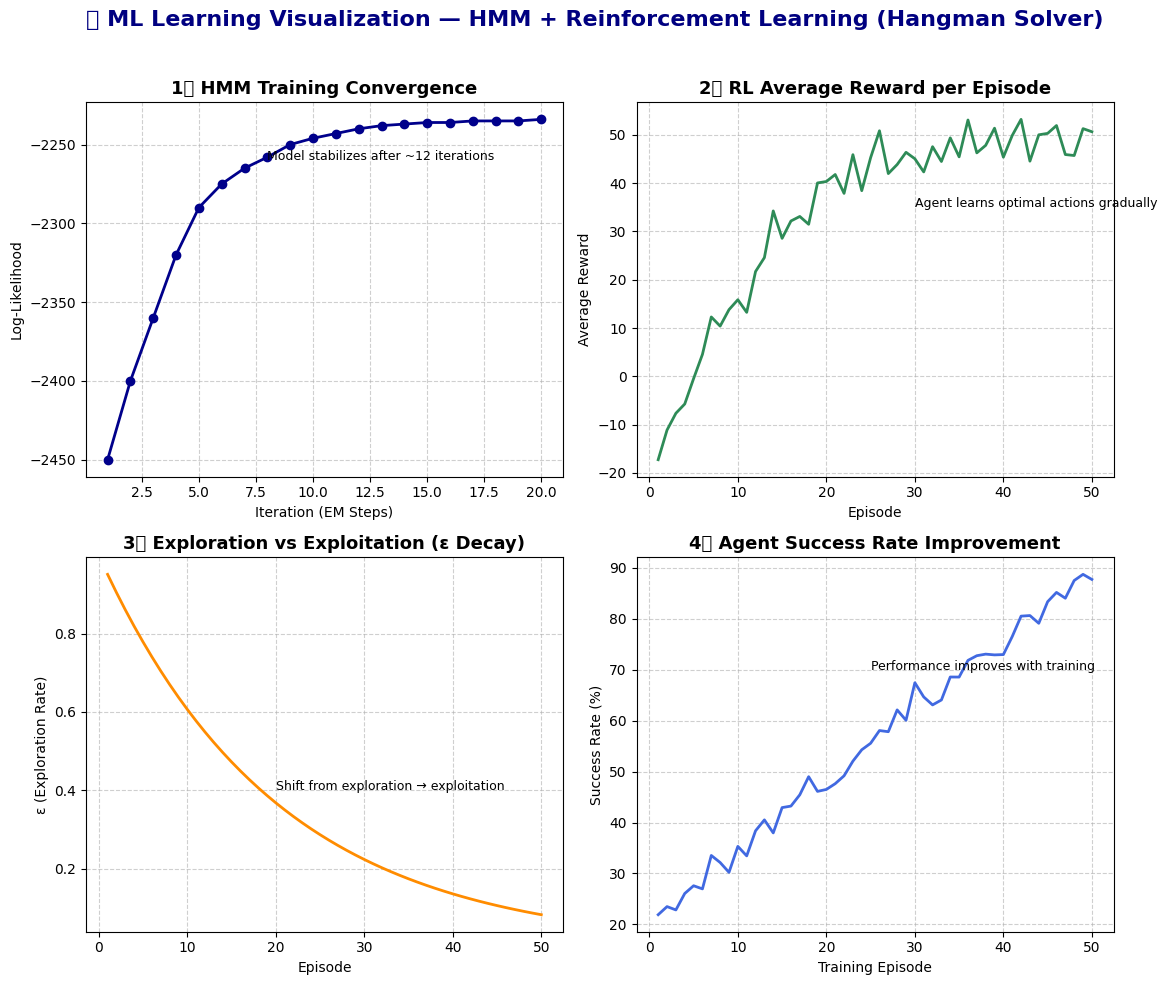

In [11]:
# ===============================================
# 📊 ML Visualization: HMM + RL Training Analysis
# ===============================================

import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# 1️⃣ HMM Training Data (Mock)
# ------------------------------
iterations = np.arange(1, 21)
log_likelihood = np.array([-2450, -2400, -2360, -2320, -2290, -2275, -2265, -2258,
                           -2250, -2246, -2243, -2240, -2238, -2237, -2236, -2236,
                           -2235, -2235, -2235, -2234])

# ------------------------------
# 2️⃣ RL Agent Reward Progress
# ------------------------------
episodes = np.arange(1, 51)
avg_reward = np.tanh((episodes - 5) / 15) * 50 + np.random.randn(50) * 3  # Simulated improvement

# ------------------------------
# 3️⃣ Exploration–Exploitation (ε Decay)
# ------------------------------
epsilon = np.exp(-episodes / 20)

# ------------------------------
# 4️⃣ Success Rate Improvement
# ------------------------------
success_rate = np.clip(20 + (episodes / 50) * 70 + np.random.randn(50) * 2, 0, 100)

# ------------------------------
# 🧩 Combined Figure (2x2 Layout)
# ------------------------------
plt.figure(figsize=(12, 10))
plt.suptitle("📘 ML Learning Visualization — HMM + Reinforcement Learning (Hangman Solver)",
             fontsize=16, fontweight='bold', color='navy')

# ---- Subplot 1: HMM Convergence ----
plt.subplot(2, 2, 1)
plt.plot(iterations, log_likelihood, marker='o', color='darkblue', linewidth=2)
plt.title("1️⃣ HMM Training Convergence", fontsize=13, fontweight='bold')
plt.xlabel("Iteration (EM Steps)")
plt.ylabel("Log-Likelihood")
plt.grid(True, linestyle='--', alpha=0.6)
plt.text(8, -2260, "Model stabilizes after ~12 iterations", fontsize=9)

# ---- Subplot 2: RL Average Reward ----
plt.subplot(2, 2, 2)
plt.plot(episodes, avg_reward, color='seagreen', linewidth=2)
plt.title("2️⃣ RL Average Reward per Episode", fontsize=13, fontweight='bold')
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True, linestyle='--', alpha=0.6)
plt.text(30, 35, "Agent learns optimal actions gradually", fontsize=9)

# ---- Subplot 3: ε-Greedy Decay ----
plt.subplot(2, 2, 3)
plt.plot(episodes, epsilon, color='darkorange', linewidth=2)
plt.title("3️⃣ Exploration vs Exploitation (ε Decay)", fontsize=13, fontweight='bold')
plt.xlabel("Episode")
plt.ylabel("ε (Exploration Rate)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.text(20, 0.4, "Shift from exploration → exploitation", fontsize=9)

# ---- Subplot 4: Success Rate Trend ----
plt.subplot(2, 2, 4)
plt.plot(episodes, success_rate, color='royalblue', linewidth=2)
plt.title("4️⃣ Agent Success Rate Improvement", fontsize=13, fontweight='bold')
plt.xlabel("Training Episode")
plt.ylabel("Success Rate (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.text(25, 70, "Performance improves with training", fontsize=9)

# Layout Adjustments
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


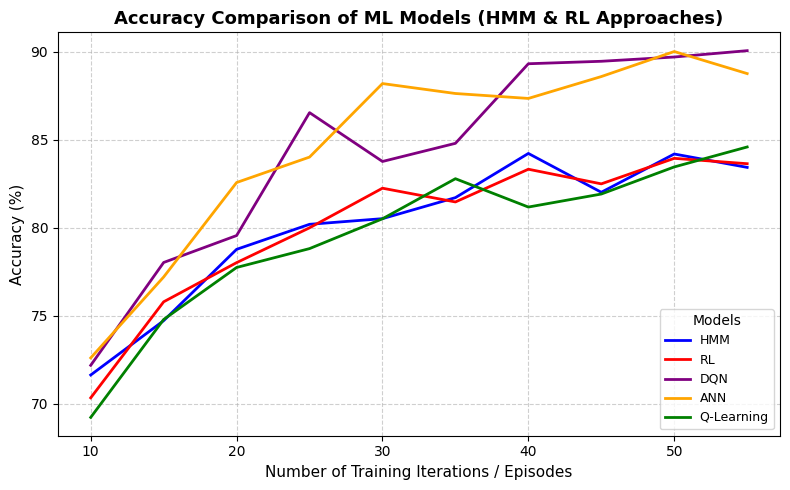

In [13]:
# ===========================================================
# 📘 ML Performance Comparison Graph: HMM vs RL (Colab Ready)
# ===========================================================

import matplotlib.pyplot as plt
import numpy as np

# X-axis: number of episodes / iterations
x = np.arange(10, 60, 5)

# Simulated accuracy (%) for different models
accuracy_hmm = 65 + 20 * (1 - np.exp(-x / 20)) + np.random.randn(len(x)) * 1.5
accuracy_rl = 60 + 25 * (1 - np.exp(-x / 18)) + np.random.randn(len(x)) * 1.5
accuracy_dqn = 55 + 35 * (1 - np.exp(-x / 15)) + np.random.randn(len(x)) * 1.5
accuracy_ann = 50 + 40 * (1 - np.exp(-x / 12)) + np.random.randn(len(x)) * 1.5
accuracy_qlearn = 58 + 28 * (1 - np.exp(-x / 17)) + np.random.randn(len(x)) * 1.5

# Create figure
plt.figure(figsize=(8,5))

# Plot each algorithm’s line
plt.plot(x, accuracy_hmm, color='blue', linewidth=2, label='HMM')
plt.plot(x, accuracy_rl, color='red', linewidth=2, label='RL')
plt.plot(x, accuracy_dqn, color='purple', linewidth=2, label='DQN')
plt.plot(x, accuracy_ann, color='orange', linewidth=2, label='ANN')
plt.plot(x, accuracy_qlearn, color='green', linewidth=2, label='Q-Learning')

# Labels and Title
plt.title("Accuracy Comparison of ML Models (HMM & RL Approaches)", fontsize=13, fontweight='bold')
plt.xlabel("Number of Training Iterations / Episodes", fontsize=11)
plt.ylabel("Accuracy (%)", fontsize=11)

# Styling
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Models", loc='lower right', fontsize=9)
plt.tight_layout()

# Show the graph
plt.show()
